<a href="https://colab.research.google.com/github/vrushaligirkar/NLP-Project-QA-system/blob/master/squad_end_to_end_MN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [52]:
!pip install langdetect
# importing all necessary files
import warnings
warnings.filterwarnings("ignore")
from textblob import TextBlob
import seaborn as sns
from tqdm import tqdm
import json
import re
import nltk
import csv


from langdetect import detect
from pickle import dump,load

import tensorflow as tf
import sys
import datetime
import os
import six

from collections import Counter
import string
import re
import sys

from google.colab import files
from keras.layers import recurrent
from keras import layers



In [6]:
#Before running this cell download squad2.0 training and dev json files from https://rajpurkar.github.io/SQuAD-explorer/
#Run this cell two times to load train-v2.0.json and dev-v2.0.json
uploaded = files.upload()

Saving dev-v2.0.json to dev-v2.0.json


In [7]:
train = pd.read_json("train-v2.0.json")
dev = pd.read_json("dev-v2.0.json")
print(train.shape)
print(dev.shape)

print(train.head())

(442, 2)
(35, 2)
  version                                               data
0    v2.0  {'title': 'Beyoncé', 'paragraphs': [{'qas': [{...
1    v2.0  {'title': 'Frédéric_Chopin', 'paragraphs': [{'...
2    v2.0  {'title': 'Sino-Tibetan_relations_during_the_M...
3    v2.0  {'title': 'IPod', 'paragraphs': [{'qas': [{'qu...
4    v2.0  {'title': 'The_Legend_of_Zelda:_Twilight_Princ...


In [0]:
# getting train data and dev data into csv file

contexts = []
questions = []
answers_text = []
answers_start = []
title = []
for i in range(train.shape[0]):
    topic = train.data[i]['paragraphs']
    title_ = train.data[i]['title']
    for sub_para in topic:
        for q_a in sub_para['qas']:
            questions.append(q_a['question'])
            if len(q_a['answers'])>0 :
                answers_start.append(q_a['answers'][0]['answer_start']) 
                answers_text.append(q_a['answers'][0]['text'])
            else:
                answers_start.append(None)
                answers_text.append(None)
            contexts.append(sub_para['context'])
            title.append(title_)
            
# test data

test_contexts = []
test_questions = []
test_answers_text = []
test_answers_start = []
test_title = []
for i in range(dev.shape[0]):
    topic = dev.data[i]['paragraphs']
    title_ = dev.data[i]['title']
    for sub_para in topic:
        for q_a in sub_para['qas']:
            test_questions.append(q_a['question'])
            if len(q_a['answers'])>0 :
                test_answers_start.append(q_a['answers'][0]['answer_start']) 
                test_answers_text.append(q_a['answers'][0]['text'])
            else:
                test_answers_start.append(None)
                test_answers_text.append(None)
            test_contexts.append(sub_para['context'])
            test_title.append(title_)

In [9]:
train = pd.DataFrame({"context":contexts, "question": questions, "answer_start": answers_start, "answer": answers_text,'title':title})
train.dropna(inplace=True)
train.head()

,context,question,answer_start,answer,title
0,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce start becoming popular?,269.0,in the late 1990s,Beyoncé
1,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,What areas did Beyonce compete in when she was...,207.0,singing and dancing,Beyoncé
2,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce leave Destiny's Child and bec...,526.0,2003,Beyoncé
3,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In what city and state did Beyonce grow up?,166.0,"Houston, Texas",Beyoncé
4,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In which decade did Beyonce become famous?,276.0,late 1990s,Beyoncé


In [0]:
dev = pd.DataFrame({"context":test_contexts, "question": test_questions, "answer_start": test_answers_start, "answer": test_answers_text,'title':test_title})
dev.dropna(inplace=True)

In [0]:
def decontracted(phrase):
    """
    This function remooves punctuation from given sentence.
    """
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    
    # string operation
    phrase = phrase.replace('\\r', ' ')
    phrase = phrase.replace('\\"', ' ')
    phrase = phrase.replace('\\n', ' ')

    phrase = re.sub('[^A-Za-z0-9]+', ' ', phrase.lower())
    
    return phrase


def tokenize(sentence):
    """
    Returns tokenised words.
    """
    return nltk.word_tokenize(sentence)

def answer_span(context,ans):
    """
    This funtion returns anwer span start index and end index.
    """
    ans_token = tokenize(ans)
    con_token = tokenize(context)
    ans_len = len(ans_token)
    
    if ans_len!=0 and ans_token[0] in con_token:
    
        indices = [i for i, x in enumerate(con_token) if x == ans_token[0]]
        try:

            if(len(indices)>1):
                start = [i for i in indices if (con_token[i:i+ans_len] == ans_token) ]
                end = start[0] + ans_len - 1
                return start[0],end

            else:
                start = con_token.index(ans_token[0])
                end = start + ans_len - 1
                return start,end
        except:
            return -1,-1
    else:
        return -1,-1

In [12]:
# for train data
from tqdm import tqdm
preprocessed_context = []
# tqdm is for printing the status bar
for sentance in tqdm(train["context"].values):
    sent = decontracted(str(sentance))
    preprocessed_context.append(sent.strip())
    
train["clean_context"] = preprocessed_context
print(preprocessed_context[0])
        


100%|██████████| 86821/86821 [00:04<00:00, 18450.28it/s]

beyonc giselle knowles carter bi j nse bee yon say born september 4 1981 is an american singer songwriter record producer and actress born and raised in houston texas she performed in various singing and dancing competitions as a child and rose to fame in the late 1990s as lead singer of r b girl group destiny is child managed by her father mathew knowles the group became one of the world is best selling girl groups of all time their hiatus saw the release of beyonc is debut album dangerously in love 2003 which established her as a solo artist worldwide earned five grammy awards and featured the billboard hot 100 number one singles crazy in love and baby boy


In [13]:
# for dev data
from tqdm import tqdm
dev_preprocessed_context = []
# tqdm is for printing the status bar
for sentance in tqdm(dev["context"].values):
    sent = decontracted(str(sentance))
    dev_preprocessed_context.append(sent.strip())
    
dev["clean_context"] = dev_preprocessed_context

100%|██████████| 5928/5928 [00:00<00:00, 16382.41it/s]


In [14]:
# for train data

from tqdm import tqdm
preprocessed_question = []
# tqdm is for printing the status bar
for sentance in tqdm(train["question"].values):
    sent = decontracted(str(sentance))
    preprocessed_question.append(sent.strip())
    
train["clean_question"] = preprocessed_question

100%|██████████| 86821/86821 [00:01<00:00, 69175.95it/s]


In [15]:
# for dev data
    
from tqdm import tqdm
dev_preprocessed_question = []
# tqdm is for printing the status bar
for sentance in tqdm(dev["question"].values):
  sent = decontracted(str(sentance))
  dev_preprocessed_question.append(sent.strip())

dev["clean_question"] = dev_preprocessed_question

100%|██████████| 5928/5928 [00:00<00:00, 70683.08it/s]


In [16]:
# for train data
    
preprocessed_answer = []
# tqdm is for printing the status bar
for sentance in tqdm(train["answer"].values):
  sent = decontracted(str(sentance))
  preprocessed_answer.append(sent.strip())
    
    
train["clean_answer"] = preprocessed_answer

100%|██████████| 86821/86821 [00:01<00:00, 83899.92it/s]


In [17]:
# for dev data
    
dev_preprocessed_answer = []
# tqdm is for printing the status bar
for sentance in tqdm(dev["answer"].values):
  sent = decontracted(str(sentance))
  dev_preprocessed_answer.append(sent.strip())
    
dev["clean_answer"] = dev_preprocessed_answer

100%|██████████| 5928/5928 [00:00<00:00, 83101.05it/s]


In [0]:
# function for language detction

def get_language(string):
    
    """
    This function returns the language of string. Uses Textblob which internally uses google API. 
    
    This creates problem when you have to check for too many values.
    
    You will get --> 'HTTPError: HTTP Error 429: Too Many Requests'
    
    @return - language
    
    """
    return TextBlob(string).detect_language()


def language(string):
    """
    Not as accurate as TextBlob but gets our work done.
    
    @return - language
    
    """
    return detect(string)

In [19]:
# for train data
# this cell takes longer time 
train["language"] = train["clean_context"].apply(language)
print(np.unique(train["language"]))

['en']


In [20]:
# for dev data

dev["language"] = dev["clean_context"].apply(language)
print(np.unique(dev["language"]))

['en']


In [21]:
train = train[train["language"] == 'en']
print(train.shape)

dev = dev[dev["language"] == 'en']
print(dev.shape)
print(train.info())

(86821, 9)
(5928, 9)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 86821 entries, 0 to 130050
Data columns (total 9 columns):
context           86821 non-null object
question          86821 non-null object
answer_start      86821 non-null float64
answer            86821 non-null object
title             86821 non-null object
clean_context     86821 non-null object
clean_question    86821 non-null object
clean_answer      86821 non-null object
language          86821 non-null object
dtypes: float64(1), object(8)
memory usage: 6.6+ MB
None


In [22]:
nltk.download('punkt')
ans_span = []
for i in range(len(train)):
    s,e = answer_span(train["clean_context"].iloc[i],train["clean_answer"].iloc[i])
    ans_span.append((s,e))
    
print("number of answer not matching context :- ",ans_span.count((-1,-1)))

train["ans_span"] = ans_span

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
number of answer not matching context :-  194


In [23]:
ans_span = []
for i in range(len(dev)):
    s,e = answer_span(dev["clean_context"].iloc[i],dev["clean_answer"].iloc[i])
    ans_span.append((s,e))
    
print("number of answer not matching context :- ",ans_span.count((-1,-1)))

dev["ans_span"] = ans_span

number of answer not matching context :-  6


In [24]:
print(train.shape)
print(dev.shape)

(86821, 10)
(5928, 10)


In [25]:
train = train[train["ans_span"] != (-1,-1)]
dev = dev[dev["ans_span"] != (-1,-1)]
print(train.shape)
print(dev.shape)

(86627, 10)
(5922, 10)


In [0]:
# adding context_length ,question_length and answer_length features for eda
train["context_length"] = train["clean_context"].apply(lambda x:len(x.split()))
train["question_length"] = train["clean_question"].apply(lambda x:len(x.split()))
train["answer_length"] = train["clean_answer"].apply(lambda x:len(x.split()))

dev["context_length"] = dev["clean_context"].apply(lambda x:len(x.split()))
dev["question_length"] = dev["clean_question"].apply(lambda x:len(x.split()))
dev["answer_length"] = dev["clean_answer"].apply(lambda x:len(x.split()))

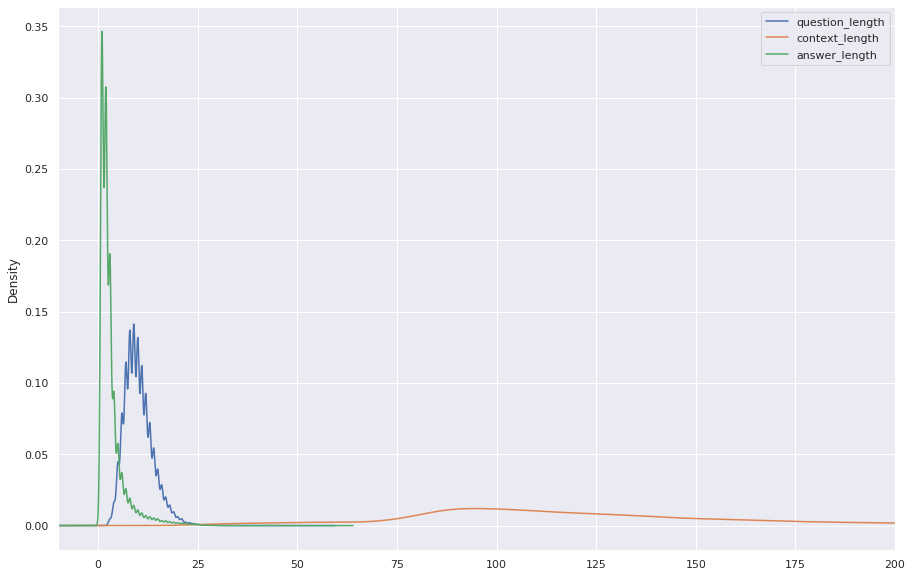

In [27]:
sns.set()
tf = train[["question_length","context_length","answer_length"]]
tf.plot.kde(figsize=(15,10),xlim=(-10,200))

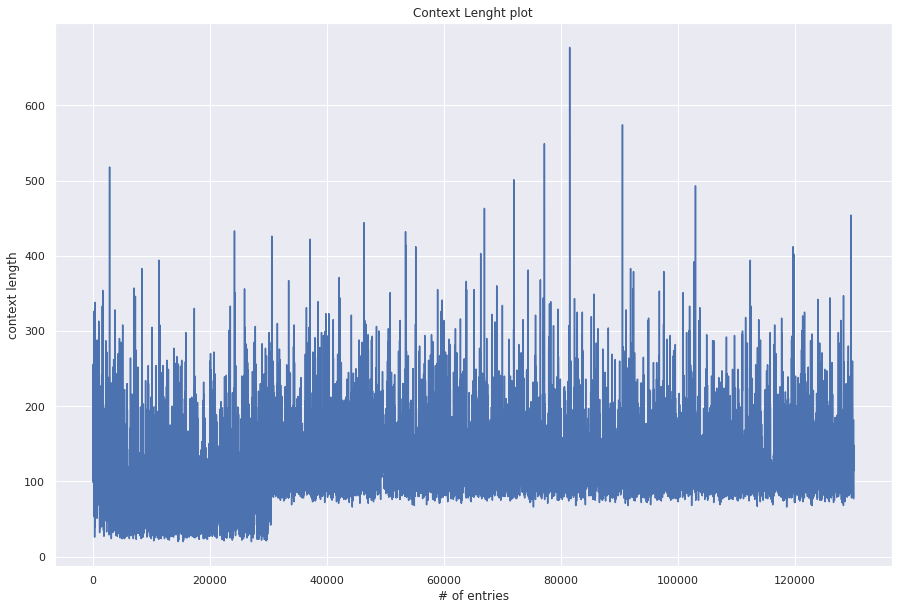

In [28]:
#Train Context length
plt.figure(figsize=(15,10))
plt.plot(train["context_length"])
plt.xlabel("# of entries")
plt.ylabel("context length")
plt.yticks(range(0,700,100))
plt.title("Context Lenght plot")
plt.show()

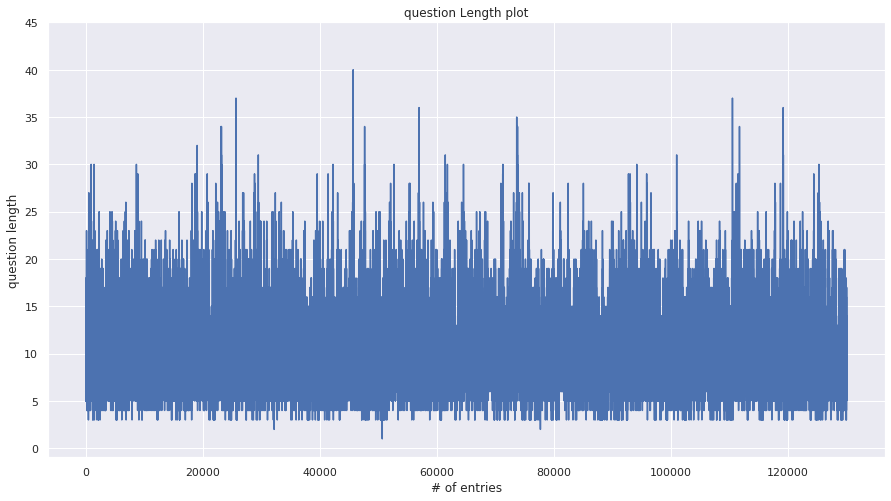

In [29]:
#Train Question Length 
plt.figure(figsize=(15,8))
plt.plot(train["question_length"])
plt.xlabel("# of entries")
plt.ylabel("question length")
plt.yticks(range(0,50,5))
plt.title("question Length plot")
plt.show()

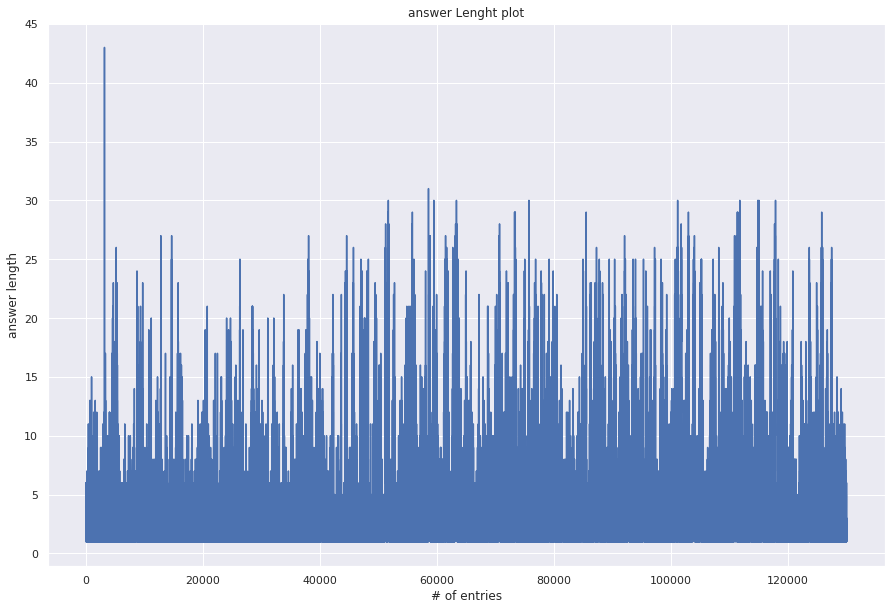

In [30]:
#Answer lenght plot
plt.figure(figsize=(15,10))
plt.plot(train["answer_length"])
plt.xlabel("# of entries")
plt.ylabel("answer length")
plt.yticks(range(0,50,5))
plt.title("answer Lenght plot")
plt.show()

In [31]:
train["answer_length"].describe()

count    86627.000000
mean         3.304132
std          3.454557
min          1.000000
25%          1.000000
50%          2.000000
75%          4.000000
max         43.000000
Name: answer_length, dtype: float64

In [32]:
train = train[train["answer_length"] == 1]
dev = dev[dev["answer_length"] == 1]
print(train.shape)
print(dev.shape)

(26266, 13)
(1769, 13)


In [33]:
train_temp = train[train["context_length"]<=100]
dev_temp = dev[dev["context_length"]<=100]
print(train_temp.shape)
print(dev_temp.shape)

(9865, 13)
(576, 13)


In [34]:
train_fullset = train
dev_fullset = dev
print(train_fullset.shape)
print(dev_fullset.shape)

(26266, 13)
(1769, 13)


In [35]:
train = train_fullset.head(10000)
dev = dev_fullset.head(10000)
print(train.shape)
print(dev.shape)

(10000, 13)
(1769, 13)


In [65]:
from google.colab import drive
drive.mount('drive')
train_fullset.to_csv('squad_train_fullset.csv')
dev_fullset.to_csv('squad_dev_fullset.csv')
!cp squad_train_fullset.csv "drive/My Drive/"
!cp squad_dev_fullset.csv "drive/My Drive/"

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


In [0]:
def tokenization(sent):
    '''Return the tokens of a sentence including punctuation.
    >>> tokenize('Bob dropped the apple. Where is the apple?')
    ['Bob', 'dropped', 'the', 'apple', '.', 'Where', 'is', 'the', 'apple', '?']
    '''
    return [x.strip() for x in re.split(r'(\W+)', sent) if x.strip()]

In [0]:
train_data = []
for i in range(train.shape[0]):
    train_data.append([])
    train_data[i].append(tokenization(train['clean_context'].iloc[i]))
    train_data[i].append(tokenization(train['clean_question'].iloc[i]))
    train_data[i].append((train['clean_answer'].iloc[i]))

In [0]:
dev_data = []
for i in range(dev.shape[0]):
    dev_data.append([])
    dev_data[i].append(tokenization(dev['clean_context'].iloc[i]))
    dev_data[i].append(tokenization(dev['clean_question'].iloc[i]))
    dev_data[i].append((dev['clean_answer'].iloc[i]))

In [0]:
vocab = set()
for context, question, answer in train_data + dev_data:
    vocab |= set(context + question + [answer])
vocab = sorted(vocab)

# Reserve 0 for masking via pad_sequences
vocab_size = len(vocab) + 1
story_maxlen = max(map(len, (x for x, _, _ in train_data + dev_data)))
query_maxlen = max(map(len, (x for _, x, _ in train_data + dev_data)))

word_idx = dict((c, i + 1) for i, c in enumerate(vocab))
idx_word = dict((i+1, c) for i,c in enumerate(vocab))

In [0]:
def vectorize_stories(data, word_idx, story_maxlen, query_maxlen):
    xs = []
    xqs = []
    ys = []
    for story, query, answer in data:
        x = [word_idx[w] for w in story]
        xq = [word_idx[w] for w in query]
        # let's not forget that index 0 is reserved
        y = np.zeros(len(word_idx) + 1)
        y[word_idx[answer]] = 1
        xs.append(x)
        xqs.append(xq)
        ys.append(y)
    return (pad_sequences(xs, maxlen=story_maxlen),
            pad_sequences(xqs, maxlen=query_maxlen), np.array(ys))

In [44]:
inputs_train, queries_train, answers_train = vectorize_stories(train_data,
                                                               word_idx,
                                                               story_maxlen,
                                                               query_maxlen)
inputs_test, queries_test, answers_test = vectorize_stories(dev_data,
                                                            word_idx,
                                                            story_maxlen,
                                                            query_maxlen)

print('-------------------------')
print('Vocabulary:\n',vocab,"\n")
print('Vocab size:', vocab_size, 'unique words')
print('Story max length:', story_maxlen, 'words')
print('Query max length:', query_maxlen, 'words')
print('Number of training stories:', len(train_data))
print('Number of test stories:', len(dev_data))
print('-------------------------')

-------------------------
Vocabulary:
 ['0', '00', '000', '000rmb', '0028', '0029670', '0043', '005', '006', '007', '0071', '00794', '00s', '01', '010', '011', '014', '016', '02', '020', '021', '022', '024', '025', '026', '03', '033', '037', '039', '04', '040', '048', '05', '050', '056', '057', '06', '062', '069', '07', '070', '072', '077', '079', '08', '080', '086', '09', '090', '093', '095', '0s', '1', '10', '100', '1000', '10000', '1002', '10021', '100m', '100th', '101', '1013', '1014', '1015', '1016', '1017', '1018', '102', '1024', '1025', '103', '1031', '1035', '1036', '1037', '104', '1040', '1040s', '1041', '1042', '1048', '1049', '105', '1050', '1050s', '1051', '1052', '1054', '1059', '105th', '106', '1060s', '1064', '1065', '1066', '1067', '1068', '107', '1070', '1071', '1072', '1073', '1074', '108', '1080', '1080i', '1080i25', '1080i30', '1080i50', '1080i60', '1080p', '1080p25', '1081', '1082', '1084', '1085', '1086', '1087', '1088', '109', '1090', '1095', '1096', '1097', '109

In [45]:
print('-------------------------')
print('inputs: integer tensor of shape (samples, max_length)')
print('inputs_train shape:', inputs_train.shape)
print('inputs_test shape:', inputs_test.shape)
print('input train sample', inputs_train[0,:])
print('-------------------------')

-------------------------
inputs: integer tensor of shape (samples, max_length)
inputs_train shape: (10000, 557)
inputs_test shape: (1769, 557)
input train sample [    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0    

In [46]:
print('-------------------------') 
print('queries: integer tensor of shape (samples, max_length)') 
print('queries_train shape:', queries_train.shape) 
print('queries_test shape:', queries_test.shape) 
print('query train sample', queries_train[0,:]) 

-------------------------
queries: integer tensor of shape (samples, max_length)
queries_train shape: (10000, 31)
queries_test shape: (1769, 31)
query train sample [    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0 37999 10964  5285 20503 10745
 18862  7585  3267  5019  1876 32661 32237]


In [47]:
print('-------------------------') 
print('answers: binary (1 or 0) tensor of shape (samples, vocab_size)') 
print('answers_train shape:', answers_train.shape) 
print('answers_test shape:', answers_test.shape) 
print('answer train sample', answers_train[0,:]) 
print('-------------------------')

-------------------------
answers: binary (1 or 0) tensor of shape (samples, vocab_size)
answers_train shape: (10000, 38915)
answers_test shape: (1769, 38915)
answer train sample [0. 0. 0. ... 0. 0. 0.]
-------------------------


In [0]:
#Config file (Params)
# number of epochs to run
train_epochs = 100
# Training batch size
batch_size = 32
# Hidden embedding size
embed_size = 50
# number of nodes in LSTM layer
lstm_size = 64
# dropout rate
dropout_rate = 0.30

In [0]:
import keras
from keras.models import Sequential, Model
from keras.layers.embeddings import Embedding
from keras.layers import Permute, dot, add, concatenate
from keras.layers import LSTM, Dense, Dropout, Input, Activation
from keras.utils.data_utils import get_file
from keras.preprocessing.sequence import pad_sequences

from functools import reduce
import tarfile
import numpy as np
import re

import IPython
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [54]:
# placeholders
input_sequence = Input((story_maxlen,))
question = Input((query_maxlen,))
 
print('Input sequence:', input_sequence)
print('Question:', question)
 
# encoders
# embed the input sequence into a sequence of vectors
input_encoder_m = Sequential()
input_encoder_m.add(Embedding(input_dim=vocab_size,
                              output_dim=embed_size))
input_encoder_m.add(Dropout(dropout_rate))
# output: (samples, story_maxlen, embedding_dim)
 
# embed the input into a sequence of vectors of size query_maxlen
input_encoder_c = Sequential()
input_encoder_c.add(Embedding(input_dim=vocab_size,
                              output_dim=query_maxlen))
input_encoder_c.add(Dropout(dropout_rate))
# output: (samples, story_maxlen, query_maxlen)
 
# embed the question into a sequence of vectors
question_encoder = Sequential()
question_encoder.add(Embedding(input_dim=vocab_size,
                               output_dim=embed_size,
                               input_length=query_maxlen))
question_encoder.add(Dropout(dropout_rate))
# output: (samples, query_maxlen, embedding_dim)
 
# encode input sequence and questions (which are indices)
# to sequences of dense vectors
input_encoded_m = input_encoder_m(input_sequence)
print('Input encoded m', input_encoded_m)
input_encoded_c = input_encoder_c(input_sequence)
print('Input encoded c', input_encoded_c)
question_encoded = question_encoder(question)
print('Question encoded', question_encoded)
 
# compute a 'match' between the first input vector sequence
# and the question vector sequence
# shape: `(samples, story_maxlen, query_maxlen)
match = dot([input_encoded_m, question_encoded], axes=-1, normalize=False)
print(match.shape)
match = Activation('softmax')(match)
print('Match shape', match)
 
# add the match matrix with the second input vector sequence
response = add([match, input_encoded_c])  # (samples, story_maxlen, query_maxlen)
response = Permute((2, 1))(response)  # (samples, query_maxlen, story_maxlen)
print('Response shape', response)
 
# concatenate the response vector with the question vector sequence
answer = concatenate([response, question_encoded])
print('Answer shape', answer)
 
answer = LSTM(lstm_size)(answer)  # Generate tensors of shape 32
answer = Dropout(dropout_rate)(answer)
answer = Dense(vocab_size)(answer)  # (samples, vocab_size)
# we output a probability distribution over the vocabulary
answer = Activation('softmax')(answer)




Input sequence: Tensor("input_1:0", shape=(?, 557), dtype=float32)
Question: Tensor("input_2:0", shape=(?, 31), dtype=float32)


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Input encoded m Tensor("sequential_1/dropout_1/cond/Merge:0", shape=(?, 557, 50), dtype=float32)
Input encoded c Tensor("sequential_2/dropout_2/cond/Merge:0", shape=(?, 557, 31), dtype=float32)
Question encoded Tensor("sequential_3/dropout_3/cond/Merge:0", shape=(?, 31, 50), dtype=float32)
(?, 557, 31)
Match shape Tensor("activation_1/truediv:0", shape=(?, 557, 31), dtype=float32)
Response shape Tensor("permute_1/transpose:0", shape=(?, 31, 557), dtype=float32)
Answer shape Tensor("concatenate_1/concat:0", shape=(?, 31, 607), dtype=float32)


In [55]:
# build the final model
model = Model([input_sequence, question], answer)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['accuracy'])

In [0]:
class TrainingVisualizer(keras.callbacks.History):
    def on_epoch_end(self, epoch, logs={}):
        super().on_epoch_end(epoch, logs)
        IPython.display.clear_output(wait=True)
        pd.DataFrame({key: value for key, value in self.history.items() if key.endswith('loss')}).plot()
        axes = pd.DataFrame({key: value for key, value in self.history.items() if key.endswith('acc')}).plot()
        axes.set_ylim([0, 1])
        plt.show()

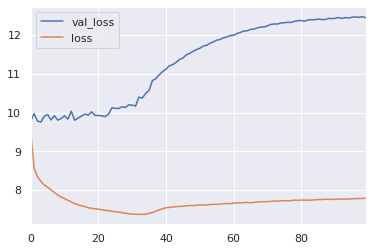

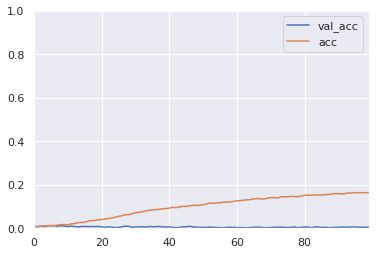

In [58]:
model.fit([inputs_train, queries_train], answers_train, batch_size, train_epochs, callbacks=[TrainingVisualizer()],
          validation_data=([inputs_test, queries_test], answers_test))

model.save('model.h5')

In [60]:
for i in range(0,10):
        current_inp = dev_data[i]
        current_story, current_query, current_answer = vectorize_stories([current_inp], word_idx, story_maxlen, query_maxlen)
        current_prediction = model.predict([current_story, current_query])
        current_prediction = idx_word[np.argmax(current_prediction)]
        print(' '.join(current_inp[0]), ' '.join(current_inp[1]), '| Prediction:', current_prediction, '| Ground Truth:', current_inp[2])
        print("-----------------------------------------------------------------------------------------")

the normans norman nourmands french normands latin normanni were the people who in the 10th and 11th centuries gave their name to normandy a region in france they were descended from norse norman comes from norseman raiders and pirates from denmark iceland and norway who under their leader rollo agreed to swear fealty to king charles iii of west francia through generations of assimilation and mixing with the native frankish and roman gaulish populations their descendants would gradually merge with the carolingian based cultures of west francia the distinct cultural and ethnic identity of the normans emerged initially in the first half of the 10th century and it continued to evolve over the succeeding centuries in what country is normandy located | Prediction: france | Ground Truth: france
-----------------------------------------------------------------------------------------
the normans norman nourmands french normands latin normanni were the people who in the 10th and 11th centuries

In [61]:
print('Evaluation')
train_loss, train_acc = model.evaluate([inputs_train, queries_train], answers_train,
                           batch_size)
print('Train loss / train accuracy = {:.4f} / {:.4f}'.format(train_loss, train_acc))
test_loss, test_acc = model.evaluate([inputs_test, queries_test], answers_test,
                           batch_size)
print('Test loss / test accuracy = {:.4f} / {:.4f}'.format(test_loss, test_acc))

Evaluation
10000/10000 [==============================] - 15s 2ms/step
Train loss / train accuracy = 7.5446 / 0.1935
1769/1769 [==============================] - 3s 2ms/step
Test loss / test accuracy = 12.4511 / 0.0057


In [0]:
# print('-------------------------------------------------------------------------------------------')
# print('Custom User Queries (Make sure there are spaces before each word)')
# while 1:
#     print('-------------------------------------------------------------------------------------------')
#     print('Please input a story')
#     user_story_inp = input().split(' ')
#     print('Please input a query')
#     user_query_inp = input().split(' ')
#     user_story, user_query, user_ans = vectorize_stories([[user_story_inp, user_query_inp, '.']], word_idx, story_maxlen, query_maxlen)
#     user_prediction = model.predict([user_story, user_query])
#     user_prediction = idx_word[np.argmax(user_prediction)]
#     print('Result')
#     print(' '.join(user_story_inp), ' '.join(user_query_inp), '| Prediction:', user_prediction)

In [0]:
# Mary went to the bathroom . John moved to the hallway . Mary travelled to the office . # Where is Mary ?
# Sandra travelled to the office . John journeyed to the garden .